# Feature Selection



In [ ]:
# DS18 ML Essentials project
# Module 5: Feature Selection

# Submitted by: Tzvi Eliezer Nir
# mail: tzvienir@gmail.com
# First submission: 29/03/2025

## In this Notebook

In the previous chapter, we created new columns using various *Feature Engineering* techniques. However, having a wide set of columns does not necessarily lead to better results. We need to ensure that all features provided to the model are meaningful; otherwise, the model may become vulnerable to overfitting.

Fortunately, there are *Regularization* methods designed specifically for this purpose. We will use **Lasso** and **Ridge**, along with other regression models, to **select a subset of features** to be used by the model.

But before, we need to perform some additional formatting, such as encoding categorical variables and explicitly specifying that the dummy columns we created along the way are boolean.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [3]:
df = pd.read_pickle('pickle/04_feature_engineering/feature_engineering.pkl')
df.head()

,track_id,track_popularity,track_album_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,month,day,decade,released_in_internet_era,feat,Remix,Love,Radio Edit,Remastered,track_artist_followers
0,0017A6SJgTbfQVU2EtsPNo,41,1srJQ0njEQgd8w4XSqI4JQ,0.682,0.401,2,-10.068,1,0.0236,0.279000,...,1,1,2000,0,0,0,0,0,0,103090.0
1,002xjHwzEx66OWFV2IP9dk,15,1ficfUnZMaY1QkNp15Slzm,0.582,0.704,5,-6.242,1,0.0347,0.065100,...,1,26,2010,1,0,0,0,0,0,366482.0
2,004s3t0ONYlzxII9PLgU6z,28,3z04Lb9Dsilqw68SHt6jLB,0.303,0.880,9,-4.739,1,0.0442,0.011700,...,11,21,2010,1,0,0,0,0,0,4132.0
3,008MceT31RotUANsKuzy3L,24,1Z4ANBVuhTlS6DprlP0m1q,0.659,0.794,10,-5.644,0,0.0540,0.000761,...,8,7,2010,1,0,0,0,0,0,557.0
4,008rk8F6ZxspZT4bUlkIQG,38,2BuYm9UcKvI0ydXs5JKwt0,0.662,0.838,1,-6.300,1,0.0499,0.114000,...,11,16,2010,1,0,0,0,0,0,2913.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28356 entries, 0 to 28355
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  28356 non-null  object 
 1   track_popularity          28356 non-null  int64  
 2   track_album_id            28356 non-null  object 
 3   danceability              28356 non-null  float64
 4   energy                    28356 non-null  float64
 5   key                       28356 non-null  int64  
 6   loudness                  28356 non-null  float64
 7   mode                      28356 non-null  int64  
 8   speechiness               28356 non-null  float64
 9   acousticness              28356 non-null  float64
 10  instrumentalness          28356 non-null  float64
 11  liveness                  28356 non-null  float64
 12  valence                   28356 non-null  float64
 13  tempo                     28356 non-null  float64
 14  durati

## Category encoding

### Cast dummy columns as `bool`

Right above 2hen using `df.info()`, we can see that the "dummy" categories we created like: genre, hot-word in the track name, released in the internet era etc. are all treated as `int64`. As those columns have just 0 and 1, it will be wise to just cast them into a boolean type:

In [5]:
bool_columns = ['released_in_internet_era', 'feat', 'Remix', 'Love', 'Radio Edit', 'Remastered', 'edm', 'latin', 'pop', 'r&b', 'rap', 'rock']
df[bool_columns] = df[bool_columns].astype(bool)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28356 entries, 0 to 28355
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  28356 non-null  object 
 1   track_popularity          28356 non-null  int64  
 2   track_album_id            28356 non-null  object 
 3   danceability              28356 non-null  float64
 4   energy                    28356 non-null  float64
 5   key                       28356 non-null  int64  
 6   loudness                  28356 non-null  float64
 7   mode                      28356 non-null  int64  
 8   speechiness               28356 non-null  float64
 9   acousticness              28356 non-null  float64
 10  instrumentalness          28356 non-null  float64
 11  liveness                  28356 non-null  float64
 12  valence                   28356 non-null  float64
 13  tempo                     28356 non-null  float64
 14  durati

### Label encoding `df.decade`

Another casting I would liked to do, is to set the `df.decade` to be a `category`.

Unfortunately, some regression models like `XGBoost` have a problem with categories, and so I will skip this step. 

In [1]:
#df.decade = df.decade.astype('category')

## Multivariable Analysis

Time for **Feature Selection**!

This is how its gonna work: we will choose a handful of regression models, among them Lasso and Ridge, and fit those models on our data. Our WHOLE data (we will not split it into train and test).

Then we will look into the feature importance of each model (or the coefficients value, in the regularization methods) and see which features should be selected to be provided to the model.

This process should help us avoid overfitting in the model-selection part.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.linear_model import Ridge

Define the target variable y, and the feature set X:

In [ ]:
y=df['track_popularity']
X = df.drop(columns=['track_popularity','track_id', 'track_album_id'])

Fitting the models, and finding for each feature, for each model, if it should be selected:

In [8]:
# Fit models and determine if a feature is selected (1) or not (0)
lasso = Lasso(alpha=0.1).fit(X, y)
lasso_selected = (np.abs(lasso.coef_) > 0).astype(int)

ridge = Ridge(alpha=0.1).fit(X, y)
ridge_selected = (np.abs(ridge.coef_) > 0).astype(int)

svm = LinearSVR(C=0.01, max_iter=5000).fit(X, y)
svm_selected = (np.abs(svm.coef_) > 0).astype(int)

gb = GradientBoostingRegressor().fit(X, y)
gb_selected = (gb.feature_importances_ > 0).astype(int)

rf = RandomForestRegressor().fit(X, y)
rf_selected = (rf.feature_importances_ > 0).astype(int)

# Create a DataFrame to store results
selection_df = pd.DataFrame({
    'Feature': X.columns,
    'Lasso': lasso_selected, 
    'SVR': svm_selected,
    'GradientBoost': gb_selected,
    'RandomForest': rf_selected,
    'Ridge': ridge_selected
})

# Sum the number of selections for each feature
selection_df['Sum'] = selection_df[['Lasso', 'SVR', 'GradientBoost', 'RandomForest','Ridge']].sum(axis=1)

# Output the results
selection_df

,Feature,Lasso,SVR,GradientBoost,RandomForest,Ridge,Sum
0,danceability,1,1,1,1,1,5
1,energy,1,1,1,1,1,5
2,key,1,1,1,1,1,5
3,loudness,1,1,1,1,1,5
4,mode,0,1,1,1,1,4
5,speechiness,0,1,1,1,1,4
6,acousticness,1,1,1,1,1,5
7,instrumentalness,1,1,1,1,1,5
8,liveness,1,1,1,1,1,5
9,valence,0,1,1,1,1,4


Our goal should be having between 15-to-30 selected features, seems that if we choose all features that are "selected" in more than 4 models we get a good subset:

In [9]:
selection_df[selection_df['Sum'] > 4].count()

Feature          22
Lasso            22
SVR              22
GradientBoost    22
RandomForest     22
Ridge            22
Sum              22
dtype: int64

Select the chosen features - and don't forget the target variable! :-)

In [10]:
final_var = selection_df[selection_df['Sum'] > 4]['Feature'].tolist()
df_model = df[final_var].copy()
df_model['track_popularity'] = df['track_popularity'].copy()

Lets have a look at the dataset after the feature selection:

In [11]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28356 entries, 0 to 28355
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   danceability            28356 non-null  float64
 1   energy                  28356 non-null  float64
 2   key                     28356 non-null  int64  
 3   loudness                28356 non-null  float64
 4   acousticness            28356 non-null  float64
 5   instrumentalness        28356 non-null  float64
 6   liveness                28356 non-null  float64
 7   tempo                   28356 non-null  float64
 8   duration_ms             28356 non-null  int64  
 9   playlist_count          28356 non-null  int64  
 10  edm                     28356 non-null  bool   
 11  pop                     28356 non-null  bool   
 12  r&b                     28356 non-null  bool   
 13  rap                     28356 non-null  bool   
 14  rock                    28356 non-null

## Save for the next chapter

In [12]:
df_model.to_csv('./data/05_feature_selection/feature_selection.csv', index=False)

df_model.to_pickle('./pickle/05_feature_selection/feature_selection.pkl')

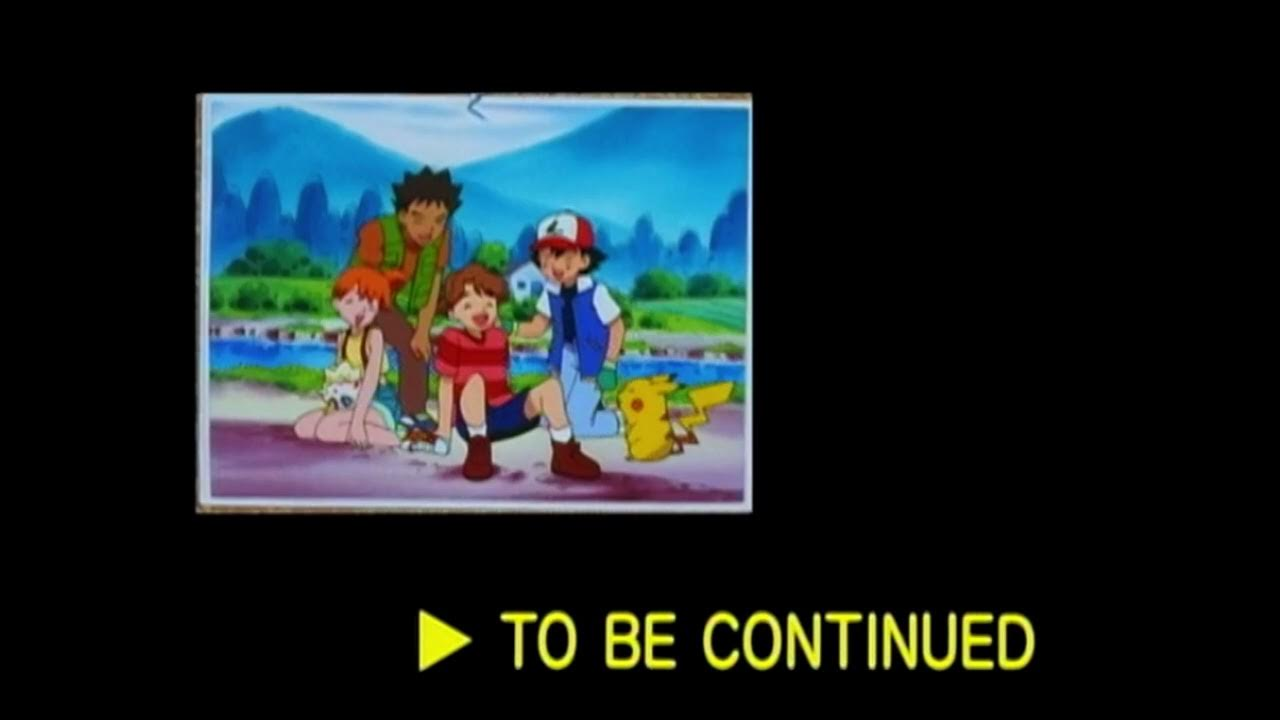